<a href="https://colab.research.google.com/github/MalikAsadAftab/Seoul-Bike-Renting-Synthetic-Data-Generation/blob/main/Seoul_Bike_Renting_Synthetic_Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'seoulbikedata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4950435%2F8335660%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T132054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D06ffe6fba5ef09b9f67331a0e510eb3bd1d957af73b9379ee6db18eb894ca7b591963c749cbe2dbf4e8ab1aa6e1930f1bbad7a7b34dce2b5b523478eca7ca35a0db9e9dc63344a22f3883352918431a39846d25fb76fbd8c340b042595bd72dad3fe156b20359c278f5618fcd1f3902a052380dc2ad719f55f38c279df481254cb8dc79e503db00c33bd4a1319bf5a3789f1f70d03f9b9786dcf3e1c079ccb4239e4de6eaa29d2d230caa31d8546cc12ad3019d645f094939299e18332d1cf7a0444c0163b7ac58672a5affb7d8372bcd5026f1906f1cd3f57408d134390435cfa5df723400f0a2ac1dc8a707b9c7dabf420fe0060510d9f124904f97b544d3d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 128783 bytes downloaded
Downloaded and uncompressed: seoulbikedata
Data source import complete.


# **1. Importing Libraries & Data**
First we need to install the [SDV](https://docs.sdv.dev/sdv/installation) package. Then we will import some libraries that we will be using throughout our implementation.

In [2]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 946.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 886.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 19.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Us

In [3]:
# Import necessary libraries
!pip install xgboost
!pip install lightgbm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sdv.datasets.local import load_csvs
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn import preprocessing, linear_model
from sklearn.preprocessing import  LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn import tree
import xgboost as xgb
from xgboost import plot_importance
from lightgbm import LGBMRegressor



import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

### *1.1 Data Loading*

We can now create a Pandas dataframe using the downloaded file, to view and analyze the data.

In [4]:
datasets = load_csvs(
    folder_name='/kaggle/input/seoulbikedata/', #Add the address of the folder where the dataset resides
    read_csv_parameters={
        'skipinitialspace': True,
        'encoding': 'unicode_escape'
    })

# the data is available under the file name
data = datasets['SeoulBikeData']

### *1.2 Data Diagnosis*

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


### *1.3 Data Duplicate Check*

In [6]:
# Check for duplicated entries.
print("Duplicate entry in data:",len(data[data.duplicated()]))
data = data.drop_duplicates()

Duplicate entry in data: 0


# **2. Feature Engineering:**

First we analyze the data in order to clean it and then feed it to synthesizer to generate data.

### *2.1_Rented Bike days Filtering*
Checking number of bikes rented against number of hours on functional and non funtioning day. Because if its not functioning then this feature in the dataset doesnot make any sense.

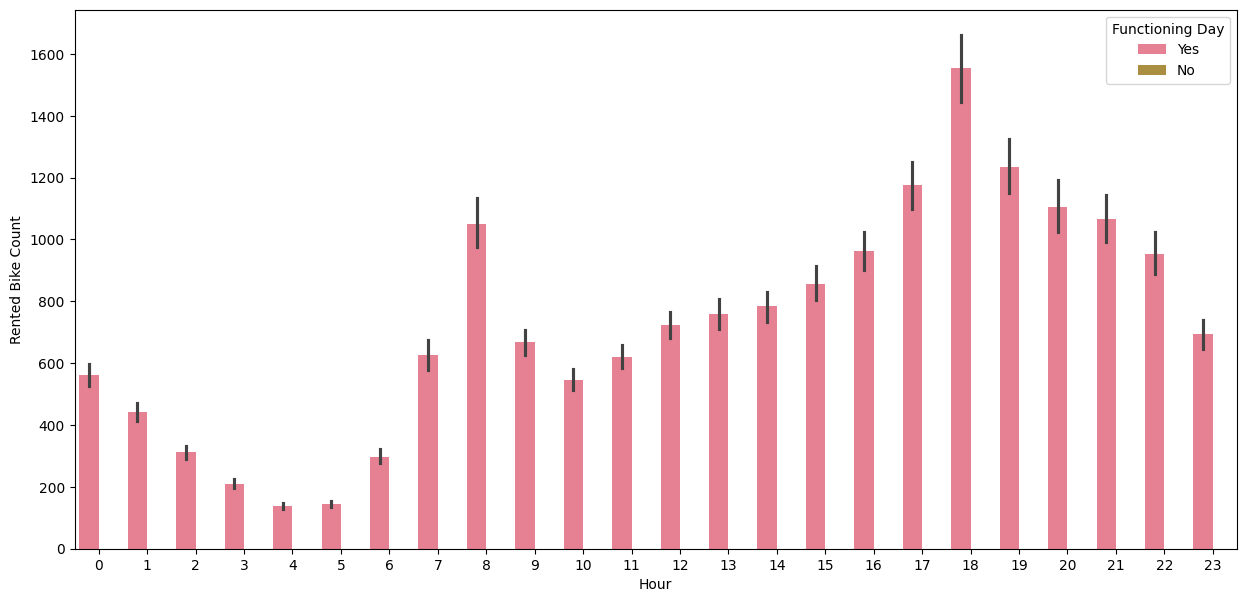

In [7]:
#for chech functioning and non functioning day ,plot (Hour Vs Rented Bike Count Graph)
def barplots(x,y,hue):
    plt.figure(figsize=(15,7))
    sns.set_palette("husl")
    sns.barplot(x=x,y=y,hue=hue,data=data);
barplots('Hour','Rented Bike Count','Functioning Day')

In [8]:
# Grouping by functioning day and calculating the total Rented Bike Count
data.groupby('Functioning Day').sum()['Rented Bike Count'].sort_values(ascending = False).reset_index()

,Functioning Day,Rented Bike Count
0,Yes,6172314
1,No,0


As per diagnosis data found that rental bike only given on Functioning Day, so remove Non Functioning Days and then remove Functioning Day Column.

In [9]:
#Removing data of non functional days (non rented days)
df=data.drop(data[data['Functioning Day'] == 'No'].index)

In [10]:
#Due to not unsefull in Functioning Day Column ,remove Functioning Day Column
df1=df.drop(['Functioning Day'], axis = 1)

In [11]:
#Checking DataFrame Shape After Removing Non Functional Day Rows And Functional Day Column
print("Filtered Dataframe with only rented bike days :",df1.shape,"\n")

Filtered Dataframe with only rented bike days : (8465, 13) 



### *2.2 Seperate Date, Month, Year from Date Column*

First, let's convert `Date` to a `datecolumn` and extract different parts of the date, as it will help us to filter the data more and find more insights from the dataset.

In [12]:
df1['Date']=pd.to_datetime(df1['Date'], errors='coerce', format='mixed')

In [13]:
#Seperate Day, Month, Year from DataFrame Column

df1['Day']=df1['Date'].dt.day
df1['Month']=df1['Date'].dt.month
df1['Year']=df1['Date'].dt.year

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8465 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8465 non-null   datetime64[ns]
 1   Rented Bike Count          8465 non-null   int64         
 2   Hour                       8465 non-null   int64         
 3   Temperature(°C)            8465 non-null   float64       
 4   Humidity(%)                8465 non-null   int64         
 5   Wind speed (m/s)           8465 non-null   float64       
 6   Visibility (10m)           8465 non-null   int64         
 7   Dew point temperature(°C)  8465 non-null   float64       
 8   Solar Radiation (MJ/m2)    8465 non-null   float64       
 9   Rainfall(mm)               8465 non-null   float64       
 10  Snowfall (cm)              8465 non-null   float64       
 11  Seasons                    8465 non-null   object        
 12  Holiday    

In [15]:
# drop the Date column after extracting necessory information
df1.drop(columns=['Date'],inplace=True)

In [16]:
df1

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month,Year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,12,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
